<a href="https://colab.research.google.com/github/bw-spotify2/ds/blob/master/Song_Selector_Model_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial building of the model.

### Load in the Dataset

In [1]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/Lambda/Unit 4/Sprint 4/SpotifyFeatures.csv')
df.sample(10)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
112651,Pop,Quavo,BUBBLE GUM,1t5lB6hvOMWdat5NKm29Qx,64,0.1140,0.799,196496,0.752,0.000000,B,0.1090,-3.734,Minor,0.2740,75.980,4/4,0.763
131818,Reggae,Sanchez,Never Dis Di Man,2ummQ4p7DvMtZZUqF58a4I,43,0.0434,0.708,240667,0.472,0.000000,F#,0.0729,-10.758,Minor,0.1530,159.901,4/4,0.742
53631,Blues,Black Diamond Heavies,Bidin' My Time,3C3FMupFEfOibl8Grn6W70,27,0.6250,0.300,316573,0.462,0.005010,G,0.1480,-11.367,Major,0.0264,147.932,3/4,0.296
114682,Rap,Speaker Knockerz,Lonely,0dbZ2iUuKvsm3FupBw6M9N,67,0.1260,0.802,186613,0.582,0.000000,C#,0.1610,-7.296,Minor,0.2350,150.002,4/4,0.338
145169,Indie,Nick Wilson,All I Ever Wanted Was You,2PyorPr6Hzdnmxm85lrohB,46,0.8940,0.613,220029,0.120,0.000000,G,0.0963,-14.099,Major,0.0328,100.044,3/4,0.137
92675,Hip-Hop,Guru Randhawa,Kaun Nachdi,7r8QeC6Uy3AbIXqH7W9y0K,54,0.0357,0.772,183373,0.830,0.000000,E,0.0419,-3.981,Minor,0.0455,127.999,4/4,0.753
173067,Comedy,Louis Katz,Chanukah,2UEZhTquCdtqf0UGWwVT0i,17,0.8170,0.557,189480,0.859,0.000000,E,0.8760,-5.275,Minor,0.7810,121.363,5/4,0.565
59835,R&B,Little Mix,Motivate,1IKzLByg2KGGUlvCDQKVJv,63,0.1790,0.652,201720,0.790,0.000002,C#,0.0595,-5.122,Major,0.0675,145.992,4/4,0.616
5395,Alternative,Brent Faiyaz,Insecure,4t5Zj9I7WDYFaYlSif13lV,53,0.5090,0.436,245619,0.306,0.000000,B,0.5910,-11.337,Minor,0.0886,95.337,5/4,0.355
39448,Electronic,Seven Lions,Rush Over Me (EFL099),4XxBGpebgw38vKRdyVhtj5,28,0.0461,0.481,267256,0.783,0.000000,A,0.5470,-6.638,Minor,0.0790,135.047,4/4,0.363


In [2]:
# Connect to the API in case we need to look at it's output

!pip install spotipy --upgrade
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import time 

client_id = '14f59f665a094868921bdd76e420d7c0'
client_secret = '5e16ddb0f2ed45a69949330bbd34351a'
username = 'mahoryu'

client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

Requirement already up-to-date: spotipy in /usr/local/lib/python3.6/dist-packages (2.12.0)


### Define the columns we want to use and make a df with it

In [3]:
# define headers
headers = ['popularity','acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence']
df_new = df[headers]

In [4]:
df_new.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0,0.611,0.389,99373,0.910,0.000,0.3460,-1.828,0.0525,166.969,0.814
1,1,0.246,0.590,137373,0.737,0.000,0.1510,-5.559,0.0868,174.003,0.816
2,3,0.952,0.663,170267,0.131,0.000,0.1030,-13.879,0.0362,99.488,0.368
3,0,0.703,0.240,152427,0.326,0.000,0.0985,-12.178,0.0395,171.758,0.227
4,4,0.950,0.331,82625,0.225,0.123,0.2020,-21.150,0.0456,140.576,0.390


In [5]:
df_new.shape

(232725, 11)

### Make the model

In [6]:
# imports 

from keras.models import Model
from keras.layers import Input, Dense
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

Using TensorFlow backend.


In [77]:
# Normalise the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_new)

#### Pickle the Scaler

In [79]:
import pickle

# Dump the trained classifier (autoencoder)  with Pickle
pickle_filename_1 = 'scaler_model.pkl'
pickled_model_1 = open(pickle_filename_1, 'wb')  # Open the file to save as pkl file
pickle.dump(scaler, pickled_model_1)
pickled_model_1.close() # Close the pickle instances

# Loading the saved model
model_pkl_1 = open(pickle_filename_1, 'rb')
scaler_model = pickle.load(model_pkl_1)
print ("Loaded model :: ", scaler_model)  # print to verify

Loaded model ::  MinMaxScaler(copy=True, feature_range=(0, 1))


#### Create actual Model

In [78]:
# set the scaled data to a new df
df_scaled = pd.DataFrame(data_scaled,columns=headers)
df_scaled.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.00,0.613454,0.356292,0.015167,0.910909,0.000000,0.339614,0.900856,0.032070,0.642704,0.814
1,0.01,0.246988,0.571934,0.022029,0.737732,0.000000,0.142710,0.834469,0.068374,0.675801,0.816
2,0.03,0.955823,0.650252,0.027969,0.131113,0.000000,0.094241,0.686429,0.014818,0.325182,0.368
3,0.00,0.705823,0.196438,0.024747,0.326313,0.000000,0.089697,0.716695,0.018311,0.665238,0.227
4,0.04,0.953815,0.294067,0.012142,0.225209,0.123123,0.194208,0.557054,0.024767,0.518516,0.390


In [9]:
# create the actual autoencoder

# set the input dimentions to what is in the df_new
input_dim = df_new.shape[1]  # 11

# Number of neurons in each Layer [11, 7, 4, 2, ...] of encoders
input_layer = Input(shape=(input_dim, ))
encoder_layer_1 = Dense(7, activation="relu", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder_layer_2 = Dense(4, activation="relu")(encoder_layer_1)
encoder_layer_3 = Dense(2, activation="relu")(encoder_layer_2)

# Crear encoder model
encoder = Model(inputs=input_layer, outputs=encoder_layer_3)

decoder_1 = Dense(4, activation='relu')(encoder_layer_3)
decoder_2 = Dense(7, activation='relu')(decoder_1)
decoder_output = Dense(input_dim, activation = 'softmax')(decoder_2)

autoencoder = Model(input_layer, decoder_output)

autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 11)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 84        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 32        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 35        
_________________________________________________________________
dense_6 (Dense)              (None, 11)                88  

In [10]:
# compile the autoencoder
autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])

# fit the model
autoencoder.fit(df_scaled, df_scaled,
                epochs=10,
                batch_size=32)
                # shuffle=True,
                # validation_data=(x_test, x_test),
                # verbose = 1,
                # callbacks=[stop, tensorboard])

Epoch 1/10
232725/232725 [==============================] - 27s 114us/step - loss: 0.1295 - accuracy: 0.6079
Epoch 2/10
232725/232725 [==============================] - 25s 109us/step - loss: 0.1233 - accuracy: 0.6873
Epoch 3/10
232725/232725 [==============================] - 25s 109us/step - loss: 0.1219 - accuracy: 0.6882
Epoch 4/10
232725/232725 [==============================] - 25s 108us/step - loss: 0.1216 - accuracy: 0.6907
Epoch 5/10
232725/232725 [==============================] - 25s 108us/step - loss: 0.1215 - accuracy: 0.6922
Epoch 6/10
232725/232725 [==============================] - 25s 109us/step - loss: 0.1215 - accuracy: 0.6910
Epoch 7/10
232725/232725 [==============================] - 25s 107us/step - loss: 0.1215 - accuracy: 0.6903
Epoch 8/10
232725/232725 [==============================] - 25s 108us/step - loss: 0.1214 - accuracy: 0.6916
Epoch 9/10
232725/232725 [==============================] - 25s 107us/step - loss: 0.1214 - accuracy: 0.6896
Epoch 10/10
232725/

In [11]:
# Use the model to predict the factors which sum up the selected atributes of the songs,
#   by making an encoded_data df.
encoded_data = pd.DataFrame(encoder.predict(data_scaled))
encoded_data.columns = ['x', 'y']
encoded_data.head()

,x,y
0,1.072640,0.684552
1,1.081470,0.460850
2,0.299888,0.724743
3,0.333239,0.720351
4,0.206765,0.508934


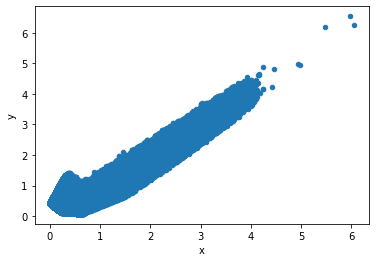

In [12]:
# plot the x,y coordinates
encoded_data.plot.scatter('x','y')

#### Pickle the Model

In [26]:
import pickle

# Dump the trained classifier (autoencoder)  with Pickle
pickle_filename = 'autoencoder_model.pkl'
pickled_model = open(pickle_filename, 'wb')  # Open the file to save as pkl file
pickle.dump(autoencoder, pickled_model)
pickled_model.close() # Close the pickle instances

# Loading the saved model
model_pkl = open(pickle_filename, 'rb')
autoencoder_model = pickle.load(model_pkl)
print ("Loaded model :: ", autoencoder_model)  # print to verify

Loaded model ::  <keras.engine.training.Model object at 0x7ff1d4cf5b70>


In [28]:
# Get test data

df_input = df_scaled[:1]
encoded_data_test = pd.DataFrame(encoder.predict(df_input))
encoded_data_test.columns = ['x', 'y']
encoded_data_test.head()

,x,y
0,1.07264,0.684552


In [51]:
test_x = encoder.predict(df_input)[0][0]
test_y = encoder.predict(df_input)[0][1]

### Get Distance

In [29]:
# example of euclidian distance
from scipy.spatial import distance
a = (1, 2, 3)
b = (4, 5, 6)
dst = distance.euclidean(a, b)

In [30]:
encoded_data.head()

,x,y,track_id
0,1.072640,0.684552,0BRjO6ga9RKCKjfDqeFgWV
1,1.081470,0.460850,0BjC1NfoEOOusryehmNudP
2,0.299888,0.724743,0CoSDzoNIKCRs124s9uTVy
3,0.333239,0.720351,0Gc6TVm52BwZD07Ki6tIvf
4,0.206765,0.508934,0IuslXpMROHdEPvSl1fTQK


In [31]:
encoded_data['track_id'] = df['track_id']
encoded_data.head()

,x,y,track_id
0,1.072640,0.684552,0BRjO6ga9RKCKjfDqeFgWV
1,1.081470,0.460850,0BjC1NfoEOOusryehmNudP
2,0.299888,0.724743,0CoSDzoNIKCRs124s9uTVy
3,0.333239,0.720351,0Gc6TVm52BwZD07Ki6tIvf
4,0.206765,0.508934,0IuslXpMROHdEPvSl1fTQK


In [18]:
# save the encoded data as a .csv file    
## Commented out so we don't run it again

# encoded_data.to_csv("encoded_data.csv", index=False)

### Test out the pickled model

In [19]:
# test out reading it in.
df1 = pd.read_csv("encoded_data")
df1.head()

,x,y,track_id
0,1.072640,0.684552,0BRjO6ga9RKCKjfDqeFgWV
1,1.081470,0.460850,0BjC1NfoEOOusryehmNudP
2,0.299888,0.724743,0CoSDzoNIKCRs124s9uTVy
3,0.333239,0.720351,0Gc6TVm52BwZD07Ki6tIvf
4,0.206765,0.508934,0IuslXpMROHdEPvSl1fTQK


In [45]:
encoded_data_test[['x','y']].values

array([[1.0726404 , 0.68455195]], dtype=float32)

In [52]:
def get_e_dist(in_df):
  return distance.euclidean(in_df[[0,1]], (test_x,test_y))

In [53]:
encoded_data['e_distance'] = encoded_data.apply(get_e_dist, axis=1)

In [54]:
encoded_data.head()

,x,y,track_id,e_distance
0,1.072640,0.684552,0BRjO6ga9RKCKjfDqeFgWV,0.000000
1,1.081470,0.460850,0BjC1NfoEOOusryehmNudP,0.223876
2,0.299888,0.724743,0CoSDzoNIKCRs124s9uTVy,0.773797
3,0.333239,0.720351,0Gc6TVm52BwZD07Ki6tIvf,0.740267
4,0.206765,0.508934,0IuslXpMROHdEPvSl1fTQK,0.883505


#### Get the 5 smallest distances and show the visuals for the top 2

In [55]:
encoded_data['e_distance'].nsmallest(5)

0         0.000000
48095     0.001967
38564     0.002626
20664     0.004379
102350    0.004379
Name: e_distance, dtype: float64

In [56]:
print(df['track_name'][0])
print(df['track_name'][48095])
print(df['track_name'][38564])

C'est beau de faire un Show
The Wire
Dream


In [57]:
df.iloc[[0,48095,38564]]


,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.61100,0.389,99373,0.910,0.0000,C#,0.346,-1.828,Major,0.0525,166.969,4/4,0.814
48095,Blues,Shovels & Rope,The Wire,6XYY2YLbbQ6oNaDTrk5DGU,41,0.00622,0.557,176890,0.554,0.0000,B,0.103,-6.506,Minor,0.0506,135.084,4/4,0.628
38564,Electronic,Moksi,Dream,2h4EfdqxQsoCEL7eKIdUGz,31,0.02050,0.829,170887,0.769,0.0663,B,0.152,-7.388,Major,0.0702,123.984,4/4,0.523


In [58]:
df_T = df_scaled.T

In [59]:
import plotly.express as px

fig = px.bar_polar(df_T, r = 0,hover_name=headers)
fig.show()

In [60]:
fig = px.bar_polar(df_T, r = 48095, hover_name=headers)
fig.show()

## Build a Function for DS Unit 3 to use

In [70]:
# test
song_at = [[0,0.611,0.389,99373,0.910,0.000,0.3460,-1.828,0.0525,166.969,0.814]]

In [101]:
### Read in the CSV ###
database = pd.read_csv('encoded_data.csv')

In [143]:
def predict(song_attributes, database):
  """
  Need to pass in a variable that is an array with the below song attributes 
  in order.
  [[popularity, acousticness, danceability, duration_ms, energy, instrumentalness,
  liveness, loudness, speechiness, tempo, valence]]
  """

  import pandas as pd

  df =  pd.DataFrame(song_attributes)

  ### Scale Input ###

  # import the pickled scaler model
  pickle_filename_1 = 'scaler_model.pkl'
  scaler_pkl = open(pickle_filename_1, 'rb')
  scaler = pickle.load(scaler_pkl) 

   # scale the input data
  input_scaled = scaler.transform(df)

  ### Encode Input ###

  # Loading the pickled autoencoder model
  pickle_filename = 'autoencoder_model.pkl'
    
  autoencoder_pkl = open(pickle_filename, 'rb')
  autoencoder = pickle.load(autoencoder_pkl)
  # encode the input data and set to variable
  input_x_y = (autoencoder.predict(input_scaled)[0][0], 
               autoencoder.predict(input_scaled)[0][1])

  # ### Read in the CSV ###
  # database = pd.read_csv('encoded_data')

  ### Get distances ###
  def get_e_dist(my_df):
    return distance.euclidean(my_df[[0,1]], input_x_y)

  database['e_distance'] = database.apply(get_e_dist, axis=1)

  five_smallest = database[['e_distance','track_id']].nsmallest(5, columns='e_distance', keep='all')

  five_closest = five_smallest['track_id']

  return five_closest.to_json()

In [144]:
test = predict(song_at, database)
test

'{"20794":"1vdN00jfVssgwJBMwmSAoT","201520":"5cYCcpCxouijqsKgtCMnWx","148670":"4eoRzZzyJ229aP2amYCbmn","205761":"3zn6JHO9WqECBdKIHwzVwO","147290":"1QlTNF43OyKK9BorIRsJ8o"}'